### P2: Baseball Managers
Thomas Hrabchak <br>
February 2016

### Introduction
Major League Baseball (MLB) is known for its all-stars making multi million dollar salaries and hitting towering homeruns. Often overlooked is the manager, who rarely leaves the duggout except to argue with an umpire, throw his hat, and get ejected from the game. Some managers are well known, have winning teams, and make it into the hall of fame, many others are forgotten by fans. This project will explore the role of the manager on an MLB team in terms of team statistics.

Behind the scenes there are many decisions being made by the manager every pitch, such as the positioning of fielders, preparation of a relief pitcher, or if the batter should try to bunt. These decisions do affect the outcome of the game and cumulatively the season. However, the results of managerial decisions manifest themselves in the performance of the players which makes directly measuring the performance of the manager difficult. 

Additionally, managers have responsibilities that are unrelated to or indirectly related to winning games, such as interacting with the media. This paper will not take into consideration skills which do not result in wins for the team, although extraneous, non-baseball related skills are relevant to assessing the overall performance of managers.

#### Background
Methods for assessing the performance of baseball managers has been proposed in several academic papers. The most popular method is James's (1986) "Pythagorean theorem", in which a manager's performance is assessed using an estimation of expected wins. Additionally, Bradbury (2006) assesses a manager in terms of impact on player performance.

In 2014, Randy Silvers and Raul Susmel explored the compensation of managers in their paper "Compensation of a Manager: The Case of Major League Baseball". Instead of attempting to directly assess the performance of a manager using a metric derived from baseball statistics, they hypothesized that the economic market of baseball managers would result in the best performing managers (highest team winning percentage and number of playoff appearances) being compensated the highest salaries. The results of their analysis showed that a manager's past performance affects the manager's current salary, but the manager's current salary does not affect the current performance of the manager's team. Silvers and Susmel note that in efficient markets the compensation of a manager is a sufficient measure of his expected productivity but has been shown to be insignificant in predicting any team performance metric. This implies that the market of MLB managers is not efficient.

Based on Silvers and Susmel and the previous papers, it seems as if there is still room for improvement in understanding the role of an MLB manager and the impact they have on the performance of their team.

### Questions
There are many possible questions about MLB managers, assesing their performance, and assessing their impact on their team. To limit the scope of this paper, only the following question will be explored:

- When a manager transfers teams, does the relative performance of any team statistic from the manager's previous team transfer to the manager's new team?

This question is actionable in terms of a statistical approach and isolates the change to the individual manager. We can generalize this question for individual managers over their entire career and then compare managerial careers based on which team statistic they were best at improving on their team.

#### Alternative Questions For Future Exploration
Below are other questions which I considered addressing in this paper. However they need further refinement in order to be actionable.
- How important is having a good manager to the success of a major league baseball team?
- Which, if any, team statistics correlate with the winningest managers?
- What are characteristics of managers that make it into the hall of fame?
- What are characteristics of managers that have short careers?
- Are any managers particularly good in the post season?
- Do any team statistics correlate with a long managerial career?
- Who is the most recent player manager and what were the circumstances?
- Are there any trends in the salaries of managers?
- Has a 'bad' manager ever won the world series?

### Wrangle
The data for this project comes from the 2014 edition of The Lahman Baseball Database. We will need to refine the data from this source to better address our question.

As an overview, below is a summary of the steps we will take in the data wrangling phase.
1. Import relevant data from The Lahman Baseball Database.
2. Appened team statistic relative performance for each team statistic for each year to the teams_df DataFrame.
3. Associate manager to team, look only at managers that lasted the full year
4. Generate table of manager team transfers
5. Average statistics for previous stint and after stint, statistics for previous year stats, after year stats
6. Aggregate transfer correlations, using average previous/after statistics, to determine which stats are most correlated to managers

#### Import Data
This project uses data from 2014 edition of The Lahman Baseball Database, hosted on github.

In [1]:
# Import Libraries and Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
%pylab inline

repository = "https://raw.githubusercontent.com/thrabchak/Udacity-Data-Analysis/"
folder = "master/P2%20Baseball%20Managers/data/"

awards_managers_df  = pd.read_csv(repository + folder + "AwardsManagers.csv")
hall_of_fame_df     = pd.read_csv(repository + folder + "HallOfFame.csv")
managers_df         = pd.read_csv(repository + folder + "Managers.csv")
master_df           = pd.read_csv(repository + folder + "Master.csv")
series_post_df      = pd.read_csv(repository + folder + "SeriesPost.csv")
teams_df            = pd.read_csv(repository + folder + "Teams.csv")
teams_franchises_df = pd.read_csv(repository + folder + "TeamsFranchises.csv")

# Show columns of the imported DataFrames
def print_df_columns(show):
    """Print columns of imported dataframes if 'show' is True."""
    if show:
        print "Awards Managers: "
        print awards_managers_df.columns
        print "Hall of Fame: "
        print hall_of_fame_df.columns
        print "Managers: "
        print managers_df.columns
        print "Master: "
        print master_df.columns
        print "Series Post: "
        print series_post_df.columns
        print "Teams: "
        print teams_df.columns
        print "Teams Franchises: "
        print teams_franchises_df.columns
    
print_df_columns(True)

Populating the interactive namespace from numpy and matplotlib
Awards Managers: 
Index([u'playerID', u'awardID', u'yearID', u'lgID', u'tie', u'notes'], dtype='object')
Hall of Fame: 
Index([u'playerID', u'yearid', u'votedBy', u'ballots', u'needed', u'votes',
       u'inducted', u'category', u'needed_note'],
      dtype='object')
Managers: 
Index([u'playerID', u'yearID', u'teamID', u'lgID', u'inseason', u'G', u'W',
       u'L', u'rank', u'plyrMgr'],
      dtype='object')
Master: 
Index([u'playerID', u'birthYear', u'birthMonth', u'birthDay', u'birthCountry',
       u'birthState', u'birthCity', u'deathYear', u'deathMonth', u'deathDay',
       u'deathCountry', u'deathState', u'deathCity', u'nameFirst', u'nameLast',
       u'nameGiven', u'weight', u'height', u'bats', u'throws', u'debut',
       u'finalGame', u'retroID', u'bbrefID'],
      dtype='object')
Series Post: 
Index([u'yearID', u'round', u'teamIDwinner', u'lgIDwinner', u'teamIDloser',
       u'lgIDloser', u'wins', u'losses', u'ties'

#### Team Statistic Overall Relative Performance
We want to append the relative statistical performance of teams to the existing teams_df DataFrame.

Relative statistical perfomance is a team's performance for a given statistic in respect to all other teams for that year. For example, the team with the most wins in a given year performed the best for that statistic ("W") and would be given a relative statistical performance ("rel_W") of 1. The team with the second most wins would be given a 2. If two teams have the same value for a given statistic, they will share the same value for relative statistical performance. For example if two teams shared the same number of wins, and that number of wins was the most for that season, both teams would share the relative statistical performance of 1. In this case, the team with the second most number of wins would be given a relative statistical performance of 3, because 2 other teams performed better. The team_stat dictionary contains the information for how a statistic should be ordered, either largest to smallest (True) or smallest to largest (False).

In [2]:
# Create a dictionary to determine how each statistic should be ordered.
# The key is the statistic and the value is True if it should be ordered from
# largest to smallest, False if it should be ordered smallest to largest.
team_stat = {
    # Overall Statistics
    'Rank':   False,  # Position in final standings
    "W":      True,  # Wins
    "L":      False, # Losses
    
    # (Sort in reverse alphabetical order)
    #"DivWin": True, # Division Winner (Y or N)
    #"WCWin":  True, # Wild Card Winner (Y or N)
    #"LgWin":  True, # League Champion(Y or N)
    #"WSWin":  True, # World Series Winner (Y or N)
    
    # Batting Statistics
    "R":      True,  # Runs scored
    "H":      True,  # Hits
    "2B":     True,  # Doubles
    "3B":     True,  # Triples
    "HR":     True,  # Homeruns
    "BB":     True,  # Walks
    "SO":     False, # Strikeouts
    "SB":     True,  # Stolen bases
    "CS":     False, # Caught stealing
    "HBP":    True,  # Batters hit by pitch
    "SF":     True,  # Sacrifice flies
    
    # Pitching Statistics
    "RA":     False, # Opponents run scored
    "ER":     False, # Earned runs allowed
    "ERA":    False, # Earned run average
    "CG":     True,  # Complete games pitched
    "SHO":    True,  # Shutouts
    "SV":     True,  # Saves
    "HA":     False, # Hits allowed
    "HRA":    False, # Homeruns allowed
    "BBA":    False, # Walks allowed
    "SOA":    True,  # Strikeouts by pitchers
    
    # Fielding Statistics
    "E":      False, # Errors
    "DP":     True,  # Double plays
    "FP":     True   # Fielding percentage
}

# Initialize data structure which we will create a DataFrame from
def create_data_structure():
    """Returns the structure for a dictionary with team stats as keys and lists as values
       stat -> []"""
    # Create list of columns
    columns = ['yearID', 'teamID']
    for key in team_stat.keys():
        columns.append('rel_' + key)
        
    # Create 2D array for data
    data = {}
    for column in columns:
        data[column] = []
        
    return data

def team_positions_for_stat(my_teams_df, year, stat):
    """Returns an ordered dictionary containing the relative positional data for a team's 
       statistic. The returned dictionary will take the form of:
       rel_position -> [stat_value, team1, team2]
       Example: {1:[10, BOS], 2:[5, NYY, MIN], 4:[3, MIA], ...}"""
    placement_dict = collections.OrderedDict() # rel_position -> [stat_value, team1, team2]
    
    # Create an ordered list of teams in this year for this statistic
    sorted_df = my_teams_df[my_teams_df.yearID == year].sort_values(stat, 
                                                         ascending=(not team_stat[stat]))
    rel_place = 1
    team_counter = 1
    placement_dict[1] = [sorted_df.iloc[0][stat], sorted_df.iloc[0].teamID]
    for i in range(1, len(sorted_df)):
        value = sorted_df.iloc[i][stat]
        team = sorted_df.iloc[i].teamID
        team_counter += 1
        if placement_dict[rel_place][0] == value:
            placement_dict[rel_place].append(team)
        else:            
            placement_dict[team_counter] = [value, team]
            rel_place = team_counter
        
    return placement_dict    

def rel_stats_for_year(my_teams_df, year):
    """Returns a dictionary of dictionaries for this year given my_teams_df.
       The return dictionary will take the form of:
       team -> {stat -> rel_place}
       Example: {'BOS': {'W': 1, 'SO': 3, ...}, 'NYY': {'W': 5, 'SO': 1, ...}, ...}"""
    # Create teams_dict
    year_dict = {} # team -> {stat -> rel_place}
    for team in pd.unique(teams_df[my_teams_df.yearID == year].teamID.ravel()):
        year_dict[team] = {}

    for stat in team_stat.keys():
        positions = team_positions_for_stat(my_teams_df, year, stat)

        for pos in positions.keys():
            for i in range(1, len(positions[pos])):
                team = positions[pos][i]
                year_dict[team]['rel_' + stat] = pos
                
    return year_dict

# Find the relative performance for each statistic as columns to teams_df
def rel_team_stats(my_teams_df):
    """Returns a DataFrame containing the relative statistical performance 
       for each team for each year."""
    data = create_data_structure()
    
    # Iterate through each year and determine the placement of each team for each statistic
    for year in pd.unique(my_teams_df.yearID.ravel()):       
        year_dict = rel_stats_for_year(my_teams_df, year)
            
        # Transform teams_dict into data
        for team in year_dict.keys():
            for col in data.keys():
                if col == 'yearID':
                    data['yearID'].append(year)
                elif col == 'teamID':
                    data['teamID'].append(team)
                else:
                    data[col].append(year_dict[team][col])
    
    # Create DataFrame    
    return pd.DataFrame(data=data)

# Merge to existing teams_df
rel_teams_df = pd.merge(teams_df, rel_team_stats(teams_df), on=['yearID', 'teamID'])
rel_teams_df.to_csv(path_or_buf='rel_teams_df.csv')

#### Associate Managers To Teams
The provided managers_df associates managers to teams by year, however there may be more than one manager for a team for a given year. This muddles the data because we cannot determine the team statistics attributable to a given manager that did not last the whole year. We will only consider managers that did last the full year. To do this we will determine the teams that had manager switches in a given year and recreate managers_df to not include managers for these team in the year of a manager switch. The result will be refined_managers_df which only contains managers that lasted the full year.

In [3]:
def get_teams_with_inseason_manager_switch():
    """Returns a dictionary containing the teams that had manager switches for
       each year.
       Takes the form of:
       year -> [team1, team2]"""
    remove_teams_dict = {}
    remove_df = managers_df[managers_df.inseason > 1]
    for year in pd.unique(remove_df.yearID.ravel()):
        remove_teams_dict[year] = []
        for team in pd.unique(remove_df[remove_df.yearID == year].teamID.ravel()):
            remove_teams_dict[year].append(team)
    return remove_teams_dict

def complete_season_managers():
    """Returns a DataFrame that is a subset of managers_df, only containing managers that
       lasted the full year."""
    remove_teams_dict = get_teams_with_inseason_manager_switch()
    index_list = []
    for i in range(len(managers_df)):
        row = managers_df.iloc[i,:]
        year = row['yearID'] 
        team = row['teamID']
        if (year not in remove_teams_dict.keys()) or (team not in remove_teams_dict[year]):
            index_list.append(i)
    
    return managers_df.iloc[index_list,:]
    
refined_managers_df = complete_season_managers()

#print get_teams_with_inseason_manager_switch()
#print refined_managers_df

#### Generate List of Manager Stints
In order to eventually determine team transitions, it might be useful to get a sense of the duration a manager worked for a given team. This consolidates multiple seasons with the same team for a given manager (considering that the manager lasted the full season for all of the included years).

A manager stint is considered the time period in which a manager remains with the same team for one or more consecutive full seasons.

In [4]:
# We want to create a DataFrame with the columns: playerID, firstYear, lastYear, teamID
def manager_stints():
    """Returns a DataFrame which contains the starting and ending year for each manager 
       for each team the manager was a part of. This will return a DataFrame with the
       columns: 'playerID', 'teamID', 'firstYear', 'lastYear', 'numYears'"""
    manager_stints = {'playerID': [], 'teamID': [], 'firstYear': [], 'lastYear': [], 
                      'numYears': [], 'stintID': []}
    stintID_counter = 1
    
    for manager in pd.unique(refined_managers_df.playerID.ravel()):
        manager_career_df = refined_managers_df[refined_managers_df.playerID == manager].\
            sort_values('yearID')
        starting_year = manager_career_df.iloc[0].yearID
        consecutive_team = manager_career_df.iloc[0].teamID
        consecutive_years_with_team = 1
        for i in range(1, len(manager_career_df)):
            year = manager_career_df.iloc[i].yearID
            team = manager_career_df.iloc[i].teamID
            expected_consecutive_year = starting_year + consecutive_years_with_team
            
            if (team == consecutive_team) and (year == expected_consecutive_year):
                consecutive_years_with_team += 1
            else:
                manager_stints['playerID'].append(manager)
                manager_stints['teamID'].append(consecutive_team)
                manager_stints['firstYear'].append(starting_year)
                manager_stints['lastYear'].append(expected_consecutive_year - 1)
                manager_stints['numYears'].append(consecutive_years_with_team)
                manager_stints['stintID'].append(stintID_counter)
                starting_year = year
                consecutive_team = team
                consecutive_years_with_team = 1
                stintID_counter += 1
                
        manager_stints['playerID'].append(manager)
        manager_stints['teamID'].append(consecutive_team)
        manager_stints['firstYear'].append(starting_year)
        manager_stints['lastYear'].append(manager_career_df.iloc[len(manager_career_df)-1].yearID)
        manager_stints['numYears'].append(consecutive_years_with_team)
        manager_stints['stintID'].append(stintID_counter)
        stintID_counter += 1
            
    return pd.DataFrame(data=manager_stints)

manager_stints_df = manager_stints()
print manager_stints_df

     firstYear  lastYear  numYears   playerID  stintID teamID
0         1871      1875         5  wrighha01        1    BS1
1         1876      1881         6  wrighha01        2    BSN
2         1882      1883         2  wrighha01        3    PRO
3         1884      1889         6  wrighha01        4    PHI
4         1891      1893         3  wrighha01        5    PHI
5         1871      1871         1   woodji01        6    CH1
6         1872      1872         1   woodji01        7    TRO
7         1875      1875         1   woodji01        8    CH2
8         1871      1871         1  paborch01        9    CL1
9         1871      1871         1  fergubo01       10    NY2
10        1872      1874         3  fergubo01       11    BR2
11        1875      1875         1  fergubo01       12    HR1
12        1876      1877         2  fergubo01       13    HAR
13        1878      1878         1  fergubo01       14    CHN
14        1880      1882         3  fergubo01       15    TRN
15      

#### Get manager transitions
We want to get the transitions between consecutive manager stints so that we can compare the relative performance of the manager's team before and after the transition. The result of this step will be a list of managers with their before stint and after stint.

We limit the transitions with the following conditions: 
- There must be a before and after stint (there is not a transition from before a manger's career to the manager's first stint, likewise for the end of the manager's career).
- The last year of the first stint and the first year of the second stint must be consecutive years. We are not considering 'gaps' in the manager's career, only consecutive year switches.

In [5]:
# Based on our question, we will only look at transitions in which a manager transitioned from a 
# team to a new team in consecutive years.

def manager_transitions():
    """Returns a DataFrame which contains the stint transitions for each manager.
       columns: 'playerID', 'firstStint', 'secondStint'"""
    manager_transitions = {'playerID': [], 'firstStint': [], 'secondStint': []}
    
    for manager in pd.unique(manager_stints_df.playerID.ravel()):
        manager_career_df = manager_stints_df[manager_stints_df.playerID == manager].\
            sort_values('firstYear')
            
        for i in range(1, len(manager_career_df)):
            previous_stint_last_year = manager_stints_df.iloc[i-1].lastYear
            current_stint_first_year = manager_stints_df.iloc[i].firstYear
            
            are_consecutive = (previous_stint_last_year + 1) == current_stint_first_year
            
            if are_consecutive:
                manager_transitions['playerID'].append(manager)
                manager_transitions['firstStint'].append(manager_stints_df.iloc[i-1].stintID)
                manager_transitions['secondStint'].append(manager_stints_df.iloc[i].stintID)
            
    return pd.DataFrame(data=manager_transitions)

manager_transitions_df = manager_transitions()
print manager_transitions_df.iloc[0]

    firstStint   playerID  secondStint
0            1  wrighha01            2
1            2  wrighha01            3
2            3  wrighha01            4
3            6   woodji01            7
4           10  fergubo01           11
5           11  fergubo01           12
6           12  fergubo01           13
7           13  fergubo01           14
8           18  youngni99           19
9           21  clappjo01           22
10          22  clappjo01           23
11          30  cravebi01           31
12          39  chapmja01           40
13          52  bancrfr99           53
14          53  bancrfr99           54
15          54  bancrfr99           55
16          67  barnibi01           68
17          72  phillho99           73
18          75  mutriji99           76
19          80  schmegu99           81
20          93  loftuto01           94
21          95  loftuto01           96
22         105  comisch01          106
23         106  comisch01          107
24         107  comisch01

#### Aggregate Relative Performance of a Stint
We will want to get the aggregate relative performance of a stint when we compare stints. In this section, relative_performance_during_stint() returns a dictionary containing the mean and std of the relative performance of each statistic during a stint.

stint  : 700
manager: bakerdu01
team   : CHN
start y: 2003
end   y: 2006
num   y: 4
--------------------
(stat, mean rank during stint, std of rank during stint, list of actual values)
('rel_SOA', 1.0, 0.0, array([1, 1, 1, 1], dtype=int64))
('rel_HA', 2.0, 0.816496580927726, array([2, 1, 3, 2], dtype=int64))
('rel_HR', 10.75, 7.135591542869215, array([14,  3,  7, 19], dtype=int64))
('rel_ERA', 11.75, 9.7082439194738, array([ 5,  3, 15, 24], dtype=int64))
('rel_RA', 11.75, 10.53169818531972, array([ 6,  2, 13, 26], dtype=int64))
('rel_ER', 11.75, 9.7082439194738, array([ 5,  3, 15, 24], dtype=int64))
('rel_FP', 12.5, 8.020806277010642, array([10,  3, 15, 22], dtype=int64))
('rel_E', 13.25, 7.5, array([15,  3, 14, 21], dtype=int64))
('rel_2B', 13.75, 9.429563439877091, array([13, 10,  5, 27], dtype=int64))
('rel_SHO', 13.75, 8.88350531415762, array([ 3, 22, 10, 20], dtype=int64))
('rel_CG', 14.5, 10.661457061146317, array([ 4, 21,  7, 26], dtype=int64))
('rel_H', 14.75, 6.396613687465162

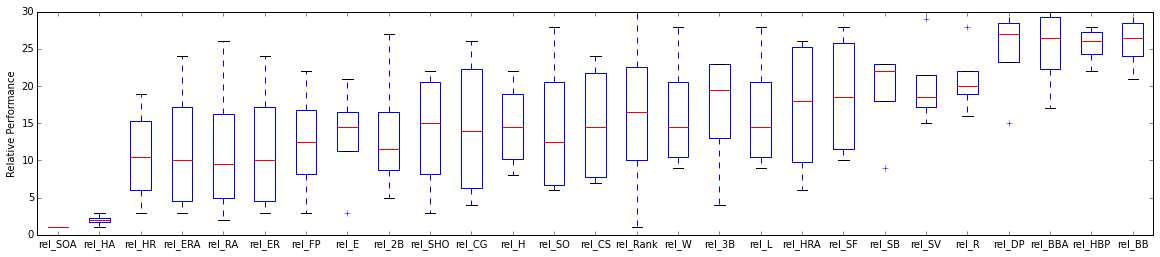

In [54]:
def relative_performance_during_stint(stint):
    """Returns a dictionary containing the average relative stats for team during a manager's stint.
       Different from a join because we are averaging the results during the stint.
       stat -> [mean rel_position, std rel_position, values]"""
    stint_df = manager_stints_df[manager_stints_df.stintID == stint]
    
    firstYear = stint_df.iloc[0].firstYear
    lastYear  = stint_df.iloc[0].lastYear
    numYears  = stint_df.iloc[0].numYears
    teamID    = stint_df.iloc[0].teamID
    manager   = stint_df.iloc[0].playerID
    
    rel_perf_dict = {'teamID': teamID, 'manager': manager, 'firstYear': firstYear,
                     'lastYear': lastYear, 'numYears': numYears, 'stintID': stint}
    
    for key in team_stat.keys():
        rel_perf_dict['rel_' + key] = []
        
    # Get mean and std for each stat in the stint 
    for stat in team_stat.keys():
        statname = 'rel_' + stat
        stat_series = rel_teams_df[(rel_teams_df.teamID == teamID) & (rel_teams_df.yearID >= firstYear)\
                                   & (rel_teams_df.yearID <= lastYear)][statname]
        rel_perf_dict[statname] = [stat_series.mean(), stat_series.std(), stat_series.values]
    
    return rel_perf_dict

def ordered_rel_stint_performance(stint):
    """Orders the results of relative_performance_during_stint() into an ordered list of tuples.
       (stat, mean, std)"""    
    perf_dict = relative_performance_during_stint(stint)
    # Create list of stat tuples
    rel_stats_list = []
    for stat in team_stat.keys():
        statname = 'rel_' + stat
        rel_stats_list.append((statname, perf_dict[statname][0], perf_dict[statname][1], perf_dict[statname][2]))
        
    rel_stats_list = sorted(rel_stats_list, key=lambda stat: stat[1])
    return rel_stats_list

def display_rel_stint_performance(stint):
    """Displays descriptive statistics for the relative performance of a stint."""
    perf_dict = relative_performance_during_stint(stint)
    rel_stats_list = ordered_rel_stint_performance(stint)
        
    out_str = 'stint  : ' + str(perf_dict['stintID'])   + '\n' +\
              'manager: ' + str(perf_dict['manager'])   + '\n' +\
              'team   : ' + str(perf_dict['teamID'])    + '\n' +\
              'start y: ' + str(perf_dict['firstYear']) + '\n' +\
              'end   y: ' + str(perf_dict['lastYear'])  + '\n' +\
              'num   y: ' + str(perf_dict['numYears'])  + '\n' +\
              '--------------------\n' + \
              '(stat, mean rank during stint, std of rank during stint, list of actual values)\n' +\
              '\n'.join(map(str, rel_stats_list))
    
    print out_str
    show_box_plots_rel_stint_performance(stint)
    
def show_box_plots_rel_stint_performance(stint):
    """Displays box plots for the relative performance of each statistic during a stint."""
    perf_dict = relative_performance_during_stint(stint)
    rel_stats_list = ordered_rel_stint_performance(stint)
    data = []
    labels = []
    for (stat, mean, std, series) in rel_stats_list:
        data.append(series)
        labels.append(stat)
    plt.boxplot(data, labels=labels)
    plt.ylabel("Relative Performance")
    plt.gcf().set_figwidth(20)
    plt.show()

display_rel_stint_performance(700)

### Explore
Now that we have our data organized, we are ready to start looking for patterns in the data. Given our starting question, we will start by comparing manager transitions by looking at the aggregate relative performance between two stints.

#### Compare Manager's Before and After Stints

In [57]:
def diff_between_stints(stint1, stint2):
    diff_dict = {}

    stint1_perf = relative_performance_during_stint(stint1)
    stint2_perf = relative_performance_during_stint(stint2)
    
    for stat in team_stat.keys():
        statname = 'rel_' + stat
        mean_diff = stint2_perf[statname][0] - stint1_perf[statname][0]
        std_diff = stint2_perf[statname][1] - stint1_perf[statname][1]
        diff_dict['d_' + stat] = [mean_diff, std_diff]

    return diff_dict

print diff_between_stints(699, 700)

{'d_DP': [16.15, 3.199609611210714], 'd_2B': [-2.8500000000000014, 1.9284524110583154], 'd_SHO': [-0.34999999999999964, 0.3012238252086856], 'd_FP': [7.3, 0.34979301640129634], 'd_SV': [10.35, 0.449581707220192], 'd_SO': [-2.1499999999999986, 3.5989249400690477], 'd_ERA': [1.25, 3.0041821324342113], 'd_BB': [17.2, -3.711655817156998], 'd_SB': [3.5, -1.2981859098631192], 'd_SF': [-0.75, -0.3382652875048624], 'd_HRA': [3.1999999999999993, 0.02439302041557312], 'd_SOA': [-15.5, -5.104464277037851], 'd_3B': [3.8000000000000007, -0.3472036659493849], 'd_BBA': [9.6, -1.2853840795448424], 'd_ER': [0.75, 2.605818668586294], 'd_HBP': [3.0, -3.5947970978850945], 'd_R': [8.4, -1.7523827231525528], 'd_W': [6.800000000000001, 0.9082952513158657], 'd_CG': [-3.3999999999999986, 2.4496769049723017], 'd_H': [-1.25, -1.7819490767917028], 'd_L': [6.5, 0.7797955192427395], 'd_CS': [0.3000000000000007, 2.005641722789787], 'd_E': [2.9499999999999993, -0.2610136794965987], 'd_RA': [0.5500000000000007, 3.2929

### Conclusion
- answers to questions based on exploration

### References

Bradbury, J. C. (2006), “Hired to Be Fired: The Publicity Value of Managers,” unpublished
manuscript, Kennesaw State University.

Lahman, Sean, comp. The Lahman Baseball Database. 2014 ed. Print. [link](http://www.seanlahman.com/baseball-archive/statistics/)

Ruggiero, J., Hadley, L., Ruggiero, G., & Knowles, S.. (1997). A Note on the Pythagorean Theorem of Baseball Production. Managerial and Decision Economics, 18(4), 335–342. Retrieved from http://www.jstor.org/stable/3108205

Silvers, Randy, and Susmel, Raul. "Compensation of a Manager: The Case of Major League Baseball." University of Houston, 1 Apr. 2014. Web. 14 Jan. 2016. [link](http://www.bauer.uh.edu/rsusmel/Academic/MLB Manager Salaries_1.pdf).


### Appendix
